In [1]:
# Titanic with neural networks!

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import chi2_contingency

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
train_data = pd.read_csv("../Datasets/Titanic/train.csv")
test_data = pd.read_csv("../Datasets/Titanic/test.csv")

column_names = train_data.columns
print(column_names)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


The data contained are the following (for my own reference):
- survival (0 or 1)
- pclass (ticket class, 1, 2 or 3)
- sex
- age
- number of siblings / spouses aboard
- number of children / parents aboard
- ticket number
- passenger fare
- cabin number
- embarked (C = Cherbourg, Q = Queenstown, S = Southampton)

As a guess, survival might be determined by sex, age and class, but whether they had or not children aboard might also be important. Ticket number is probably related to the class (wild guess), as well as the cabin number. The fare is probably related to the class.

Cabin number might play a role, as some cabin numbers were farther away from the bridge at the moment of the collision. However, these might all be useless without some sort of mapping of the possible values: e.g. it's useless to know the cabin number if we don't know which cabins were farther away from the bridge (although it might a way to reverse engineer it). 


In [6]:
print(train_data['Cabin'])
print(train_data['Ticket'])

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object
0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object


Upon further look, the cabin data contains a lot of missing data, while the ticket data are quite unintellegible. I would then skip them...

Let's start by setting down a model with:
- Pclass
- Sex
- Age
- SibSp
- Parch

In [7]:
# deal with NA in the dataset, then split in features and labels
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']
train_features = train_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Survived']].dropna().copy()
train_labels = train_features['Survived'].copy()
train_features = pd.get_dummies(train_features[features])


We now have our data. Let's start modelling.

In [8]:
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [9]:
model = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

compiled_model = model.compile(loss='binary_crossentropy', 
                               optimizer='adam', metrics=['accuracy'])

model_fit = model.fit(train_features, train_labels, epochs=20, 
                      verbose=0, validation_split=0.1)


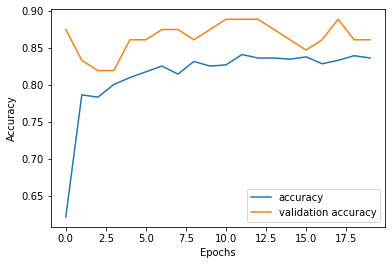

In [10]:
plt.plot(model_fit.history['accuracy'], label='accuracy')
plt.plot(model_fit.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

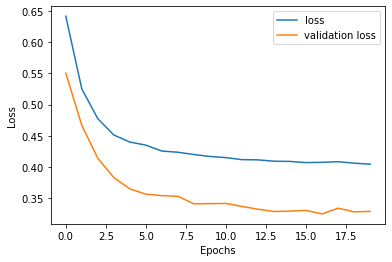

In [11]:
plt.plot(model_fit.history['loss'], label='loss')
plt.plot(model_fit.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

From testing around, with this kind of topology the sweet spot is reached at around 10-20 generations of testing. I think we are ready to try and submit!

In [12]:
test_features = pd.get_dummies(test_data[features])
predictions = (model.predict(test_features) > 0.5).astype("int32")
predictions[:,0]

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions[:,0]})
output.to_csv('dnn_submission.csv', index=False)

14/14 [==============================] - 0s 2ms/step
